# Assignment 1 – Airbnb Pricing Model (Barcelona)

**Course:** Data Analysis 3 – Prediction and Introduction to Machine Learning   
**Student:** Sabira Onbayeva  

Using historical InsideAirbnb data, this notebook builds and compares predictive models for Airbnb listing prices in   
a) Barcelona for Q1 2025  
b) Barcelona for Q3 2025  
c) Sevilla for Q3 2025


In [1]:
# Setting up environment

# Core
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

# Boosting
from xgboost import XGBRegressor

# Interpretation
import shap

# Utilities
from pathlib import Path
import time
import warnings

warnings.filterwarnings("ignore")

# Plot style 
sns.set_theme(style="whitegrid")

c:\Users\Sabira\anaconda3\envs\da3-airbnb\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Project paths
PROJECT_DIR = Path.cwd()
OUTPUT_DIR = PROJECT_DIR / "outputs"
TABLES_DIR = OUTPUT_DIR / "tables"
FIGURES_DIR = OUTPUT_DIR / "figures"

for p in [OUTPUT_DIR, TABLES_DIR, FIGURES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Output directories ready:", TABLES_DIR)

Output directories ready: c:\Users\Sabira\Data-Analysis-3\assignment_1\outputs\tables


### Part 1. Modelling
#### 1.1 Data Download and data wrangling


In [3]:
# Download data (Barcelona, Q1 2025)
BARCELONA_Q1_2025_URL = "https://data.insideairbnb.com/spain/catalonia/barcelona/2025-03-05/data/listings.csv.gz"

df_raw = pd.read_csv(BARCELONA_Q1_2025_URL)
print("Rows, columns:", df_raw.shape)
df_raw.head(5)

Rows, columns: (19422, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,18674,https://www.airbnb.com/rooms/18674,20250305023237,2025-03-06,city scrape,Huge flat for 8 people close to Sagrada Familia,110m2 apartment to rent in Barcelona. Located ...,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,...,4.70,4.80,4.32,HUTB-002062,t,29,29,0,0,0.31
1,23197,https://www.airbnb.com/rooms/23197,20250305023237,2025-03-07,city scrape,"Forum CCIB DeLuxe, Spacious, Large Balcony, relax",Beautiful and Spacious Apartment with Large Te...,"Strategically located in the Parc del Fòrum, a...",https://a0.muscache.com/pictures/miso/Hosting-...,90417,...,4.99,4.63,4.66,HUTB005057,f,1,1,0,0,0.48
2,32711,https://www.airbnb.com/rooms/32711,20250305023237,2025-03-06,city scrape,Sagrada Familia area - Còrsega 1,A lovely two bedroom apartment only 250 m from...,What's nearby <br />This apartment is located...,https://a0.muscache.com/pictures/357b25e4-f414...,135703,...,4.89,4.89,4.49,HUTB-001722,f,3,3,0,0,0.86
3,34241,https://www.airbnb.com/rooms/34241,20250305023237,2025-03-05,city scrape,Stylish Top Floor Apartment - Ramblas Plaza Real,Located in close proximity to Plaza Real and L...,NaN,https://a0.muscache.com/pictures/2437facc-2fe7...,73163,...,4.68,4.73,4.23,Exempt,f,3,3,0,0,0.14
4,34981,https://www.airbnb.com/rooms/34981,20250305023237,2025-03-05,city scrape,VIDRE HOME PLAZA REAL on LAS RAMBLAS,Spacious apartment for large families or group...,"Located in Ciutat Vella in the Gothic Quarter,...",https://a0.muscache.com/pictures/c4d1723c-e479...,73163,...,4.70,4.66,4.43,HUTB-150671,f,3,3,0,0,1.46


In [4]:
# Quick inspection
df_raw.info(show_counts=True)

# Missingness overview (top 25)
missing = (df_raw.isna().mean().sort_values(ascending=False) * 100).round(1)
missing.head(25)


<class 'pandas.DataFrame'>
RangeIndex: 19422 entries, 0 to 19421
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            19422 non-null  int64  
 1   listing_url                                   19422 non-null  str    
 2   scrape_id                                     19422 non-null  int64  
 3   last_scraped                                  19422 non-null  str    
 4   source                                        19422 non-null  str    
 5   name                                          19422 non-null  str    
 6   description                                   18676 non-null  str    
 7   neighborhood_overview                         9575 non-null   str    
 8   picture_url                                   19422 non-null  str    
 9   host_id                                       19422 non-null  int64  
 1

calendar_updated               100.0
host_neighbourhood              51.1
neighborhood_overview           50.7
neighbourhood                   50.7
host_about                      37.1
license                         32.0
review_scores_checkin           25.3
review_scores_accuracy          25.3
review_scores_value             25.3
review_scores_location          25.3
review_scores_cleanliness       25.3
review_scores_communication     25.3
reviews_per_month               25.3
review_scores_rating            25.3
last_review                     25.3
first_review                    25.3
host_location                   23.2
beds                            21.7
price                           21.4
estimated_revenue_l365d         21.4
bathrooms                       21.3
host_response_time              16.1
host_response_rate              16.1
host_acceptance_rate            14.2
bedrooms                        10.2
dtype: float64

The dataset contains 19,422 listings and 79 variables.
Several variables are identifiers (IDs, URLs), long text fields, or metadata and are excluded from modeling.

Consistent with the course case study, we focus on:
- listing characteristics (size, capacity)
- location and property type
- availability and host activity
- review information
- amenities (extracted from the amenities field)

Textual descriptions and URLs are not used.

In [9]:
# Clean target variable: price

df = df_raw.copy()

# Remove currency symbols and commas
df["price"] = (
    df["price"]
    .astype(str)
    .str.replace(r"[$,]", "", regex=True)
    .str.strip()
)

# Convert to numeric
df["price"] = pd.to_numeric(df["price"], errors="coerce")

# Drop missing or non-positive prices
df = df.dropna(subset=["price"])
df = df[df["price"] > 0]

print("Shape after cleaning price:", df.shape)
df["price"].describe()

Shape after cleaning price: (15273, 79)


count    15273.000000
mean       161.542264
std        327.006539
min          8.000000
25%         65.000000
50%        117.000000
75%        181.000000
max      10000.000000
Name: price, dtype: float64

In [17]:
# Log-transform target variable

df["log_price"] = np.log(df["price"])

df[["price", "log_price"]].describe()

,price,log_price
count,15273.000000,15273.000000
mean,161.542264,4.714891
std,327.006539,0.772274
min,8.000000,2.079442
25%,65.000000,4.174387
50%,117.000000,4.762174
75%,181.000000,5.198497
max,10000.000000,9.210340


Airbnb prices are right-skewed, with a small number of very expensive listings.
Taking logs reduces skewness, stabilizes variance, and allows models to better capture relative (percentage) price differences rather than absolute differences.

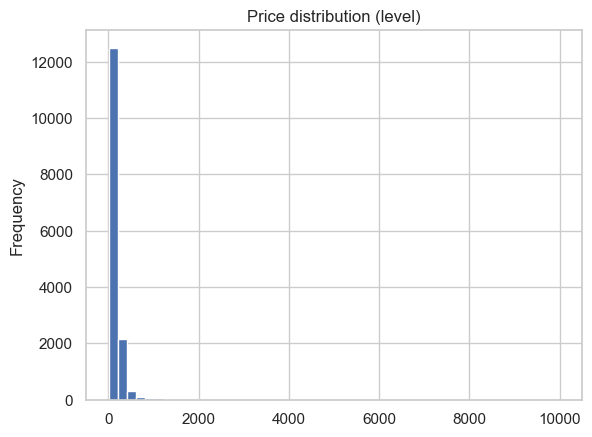

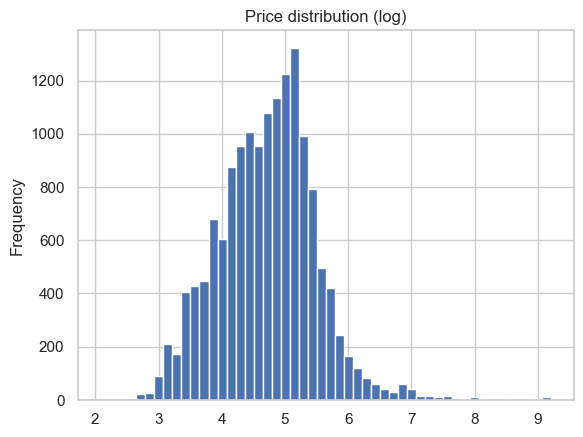

In [56]:
df["price"].plot(kind="hist", bins=50, title="Price distribution (level)")
plt.savefig(FIGURES_DIR / "price_distribution.png", dpi=150)
plt.show()

df["log_price"].plot(kind="hist", bins=50, title="Price distribution (log)")
plt.savefig(FIGURES_DIR / "log_price_distribution.png", dpi=150)
plt.show()

In [19]:
# Predictor groups

basic_numeric = [
    "accommodates",
    "bedrooms",
    "beds",
    "bathrooms",
    "minimum_nights",
    "availability_365",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count"
]

basic_categorical = [
    "room_type",
    "property_type",
    "neighbourhood_cleansed"
]

review_vars = [
    "review_scores_rating",
    "review_scores_accuracy",
    "review_scores_cleanliness",
    "review_scores_checkin",
    "review_scores_communication",
    "review_scores_location",
    "review_scores_value"
]

print("Numeric:", basic_numeric)
print("Categorical:", basic_categorical)
print("Review vars:", review_vars)

Numeric: ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'minimum_nights', 'availability_365', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']
Categorical: ['room_type', 'property_type', 'neighbourhood_cleansed']
Review vars: ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']


In [20]:
# Amenities extraction

amenities_series = (
    df["amenities"]
    .str.replace(r"[{}\"]", "", regex=True)
    .str.split(",")
)

amenities_series = amenities_series.apply(
    lambda x: [a.strip() for a in x if isinstance(a, str)]
)

from collections import Counter
amenity_counts = Counter(
    a for amenities in amenities_series for a in amenities
)

TOP_N_AMENITIES = 50
top_amenities = [a for a, _ in amenity_counts.most_common(TOP_N_AMENITIES)]

print("Top amenities:", top_amenities[:10])

Top amenities: ['Kitchen', 'Wifi', 'Hair dryer', 'Iron', 'Dishes and silverware', 'Hangers', 'Hot water', 'Refrigerator', 'Bed linens', 'Microwave']


In [21]:
# Create binary amenity indicators
for amenity in top_amenities:
    col_name = "d_" + amenity.lower().replace(" ", "_").replace("/", "_")
    df[col_name] = amenities_series.apply(lambda x: int(amenity in x))

amenity_vars = [c for c in df.columns if c.startswith("d_")]

print("Amenity variables created:", len(amenity_vars))

Amenity variables created: 50


In [22]:
PREDICTORS = basic_numeric + basic_categorical + review_vars + amenity_vars

print("Total predictors:", len(PREDICTORS))

Total predictors: 69


In [23]:
# Prepare modeling data

X = df[PREDICTORS].copy()
y = df["log_price"].copy()

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (15273, 69)
y shape: (15273,)


In [24]:
# Train–holdout split

X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape[0])
print("Holdout size:", X_holdout.shape[0])

Train size: 12218
Holdout size: 3055


In [25]:
# Variable types

numeric_features = basic_numeric + review_vars + amenity_vars
categorical_features = basic_categorical

print("Numeric features:", len(numeric_features))
print("Categorical features:", len(categorical_features))

Numeric features: 66
Categorical features: 3


In [26]:
# Preprocessing pipeline

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline ready")

Preprocessing pipeline ready


#### 1.2 Predictive Models

#### a. OLS

In [27]:
# OLS baseline

ols_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Fit
start = time.perf_counter()
ols_model.fit(X_train, y_train)
ols_time = time.perf_counter() - start

# Predict on holdout
y_pred_ols = ols_model.predict(X_holdout)

# Evaluate (RMSE + R2)
ols_mse = mean_squared_error(y_holdout, y_pred_ols)
ols_rmse = np.sqrt(ols_mse)
ols_r2 = r2_score(y_holdout, y_pred_ols)

print(f"OLS RMSE (log): {ols_rmse:.4f}")
print(f"OLS R²: {ols_r2:.4f}")
print(f"OLS fit time (sec): {ols_time:.2f}")

OLS RMSE (log): 0.4471
OLS R²: 0.6527
OLS fit time (sec): 0.18


#### b. LASSO

In [28]:
# LASSO model

lasso_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    # Required because one-hot encoding creates sparse matrix
    ("scaler", StandardScaler(with_mean=False)),
    ("model", LassoCV(
        cv=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# Fit
start = time.perf_counter()
lasso_model.fit(X_train, y_train)
lasso_time = time.perf_counter() - start

# Predict on holdout
y_pred_lasso = lasso_model.predict(X_holdout)

# Evaluate (RMSE + R2)
lasso_mse = mean_squared_error(y_holdout, y_pred_lasso)
lasso_rmse = np.sqrt(lasso_mse)
lasso_r2 = r2_score(y_holdout, y_pred_lasso)

print(f"LASSO RMSE (log): {lasso_rmse:.4f}")
print(f"LASSO R²: {lasso_r2:.4f}")
print(f"LASSO fit time (sec): {lasso_time:.2f}")


LASSO RMSE (log): 0.4452
LASSO R²: 0.6556
LASSO fit time (sec): 6.25


#### c. Random Forest

In [29]:
# Random Forest (with CV tuning)

rf_base = RandomForestRegressor(
    n_estimators=500,
    random_state=RANDOM_STATE,
    n_jobs=1  # avoid nested parallelism with GridSearch
)

rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_base)
])

rf_param_grid = {
    "model__max_features": ["sqrt", 0.3, 0.5],
    "model__min_samples_leaf": [1, 3, 5]
}

rf_search = GridSearchCV(
    rf_model,
    param_grid=rf_param_grid,
    cv=5,
    scoring="neg_mean_squared_error",  # robust across sklearn versions
    n_jobs=-1,
    verbose=1
)

start = time.perf_counter()
rf_search.fit(X_train, y_train)
rf_time = time.perf_counter() - start

print("Best RF params:", rf_search.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best RF params: {'model__max_features': 0.3, 'model__min_samples_leaf': 1}


In [30]:
# RF holdout evaluation

best_rf = rf_search.best_estimator_

y_pred_rf = best_rf.predict(X_holdout)

rf_mse = mean_squared_error(y_holdout, y_pred_rf)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_holdout, y_pred_rf)

print(f"RF RMSE (log): {rf_rmse:.4f}")
print(f"RF R²: {rf_r2:.4f}")
print(f"RF fit time incl. CV (sec): {rf_time:.2f}")

RF RMSE (log): 0.3729
RF R²: 0.7584
RF fit time incl. CV (sec): 196.11


#### d. Boosting

In [31]:
# Boosting model (XGBoost)
from xgboost import XGBRegressor

# Hyperparameter grid for tuning
# Kept intentionally small to balance performance and computation time
XGB_TUNE_GRID = {
    "model__n_estimators": [300, 600],
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [3, 5],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
}

# Build pipeline:
xgb_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", XGBRegressor(
            objective="reg:squarederror",
            random_state=RANDOM_STATE,
            tree_method="hist",
            n_jobs=1,
            verbosity=0
        ))
    ]
)

# Cross-validation setup for hyperparameter tuning
xgb_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=XGB_TUNE_GRID,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

In [32]:
# Measure total training + CV time
start = time.perf_counter()
xgb_search.fit(X_train, y_train)
xgb_time = time.perf_counter() - start

print("Best XGB params:", xgb_search.best_params_)
print(f"XGB fit time incl. CV (sec): {xgb_time:.2f}")

# Extract the best-performing model
best_xgb = xgb_search.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XGB params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 600, 'model__subsample': 0.8}
XGB fit time incl. CV (sec): 41.61


In [33]:
# Generate predictions on unseen holdout data
y_pred_xgb = best_xgb.predict(X_holdout)

# Compute RMSE and R-squared
xgb_rmse = np.sqrt(mean_squared_error(y_holdout, y_pred_xgb))
xgb_r2 = r2_score(y_holdout, y_pred_xgb)

print(f"XGB RMSE (log): {xgb_rmse:.4f}")
print(f"XGB R²: {xgb_r2:.4f}")

XGB RMSE (log): 0.3713
XGB R²: 0.7605


#### e. CART (Regression Tree) with pruning

In [ ]:
# CART
# Obtain candidate pruning parameters

from sklearn.tree import DecisionTreeRegressor

# Transform training data once (needed for pruning path)
X_train_transformed = preprocessor.fit_transform(X_train)

# Base CART model (no pruning yet)
cart_base = DecisionTreeRegressor(random_state=RANDOM_STATE)

# Get candidate ccp_alpha values from pruning path
path = cart_base.cost_complexity_pruning_path(X_train_transformed, y_train)
ccp_alphas = path["ccp_alphas"][:-1]

# Keep a manageable subset to avoid long runtimes
if len(ccp_alphas) > 50:
    idx = np.linspace(0, len(ccp_alphas) - 1, 50).astype(int)
    ccp_alphas = ccp_alphas[idx]

print(f"Number of candidate ccp_alpha values: {len(ccp_alphas)}")

Number of candidate ccp_alpha values: 50


In [35]:
# Fit pruned CART model using CV

# Pipeline: preprocessing -> CART
cart_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# Grid search over pruning parameter
cart_search = GridSearchCV(
    estimator=cart_pipeline,
    param_grid={"model__ccp_alpha": ccp_alphas},
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

# Fit and record time
start = time.perf_counter()
cart_search.fit(X_train, y_train)
cart_time = time.perf_counter() - start

best_cart = cart_search.best_estimator_

print("Best CART parameter:", cart_search.best_params_)
print(f"CART fit time incl. CV (sec): {cart_time:.2f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best CART parameter: {'model__ccp_alpha': np.float64(0.00013958985099573023)}
CART fit time incl. CV (sec): 21.19


In [36]:
# Evaluate CART on holdout set

y_pred_cart = best_cart.predict(X_holdout)

cart_rmse = np.sqrt(mean_squared_error(y_holdout, y_pred_cart))
cart_r2 = r2_score(y_holdout, y_pred_cart)

print(f"CART RMSE (log): {cart_rmse:.4f}")
print(f"CART R²: {cart_r2:.4f}")

CART RMSE (log): 0.4895
CART R²: 0.5837


### 1.3 Model comparison: Horserace table

In [37]:
results = pd.DataFrame({
    "Model": [
        "OLS",
        "LASSO",
        "Random Forest",
        "XGBoost",
        "CART"
    ],
    "RMSE (log)": [
        ols_rmse,
        lasso_rmse,
        rf_rmse,
        xgb_rmse,
        cart_rmse
    ],
    "R²": [
        ols_r2,
        lasso_r2,
        rf_r2,
        xgb_r2,
        cart_r2
    ],
    "Fit time (sec)": [
        ols_time,
        lasso_time,
        rf_time,
        xgb_time,
        cart_time
    ]
})

# Sort by RMSE (lower is better)
results = results.sort_values("RMSE (log)").reset_index(drop=True)

results

,Model,RMSE (log),R²,Fit time (sec)
0,XGBoost,0.371287,0.760472,41.612090
1,Random Forest,0.372910,0.758374,196.111955
2,LASSO,0.445202,0.655610,6.251894
3,OLS,0.447101,0.652666,0.181748
4,CART,0.489461,0.583732,21.186269


The results show clear performance differences across model classes.  
Linear models (OLS and LASSO) are fast to estimate but deliver relatively weak predictive accuracy. The regression tree (CART) performs worse than both linear and ensemble models.

Tree-based ensemble methods dominate in terms of predictive performance. Random Forest and XGBoost achieve the lowest RMSE and highest R². While their accuracy is very similar, XGBoost reaches this performance at substantially lower computational cost.

Overall, XGBoost provides the best balance between predictive accuracy and runtime.

In [37]:
results.to_csv(TABLES_DIR / "model_horserace.csv", index=False)

### 1.4 RF vs Boosting model

In [ ]:
# Extract feature names after preprocessing

feature_names = best_rf.named_steps["preprocessor"].get_feature_names_out()

print("Number of post-processed features:", len(feature_names))
print("First 10 feature names:", feature_names[:10])

Number of post-processed features: 186
First 10 feature names: ['num__accommodates' 'num__bedrooms' 'num__beds' 'num__bathrooms'
 'num__minimum_nights' 'num__availability_365' 'num__number_of_reviews'
 'num__reviews_per_month' 'num__calculated_host_listings_count'
 'num__review_scores_rating']


Random Forest - Top 10 features


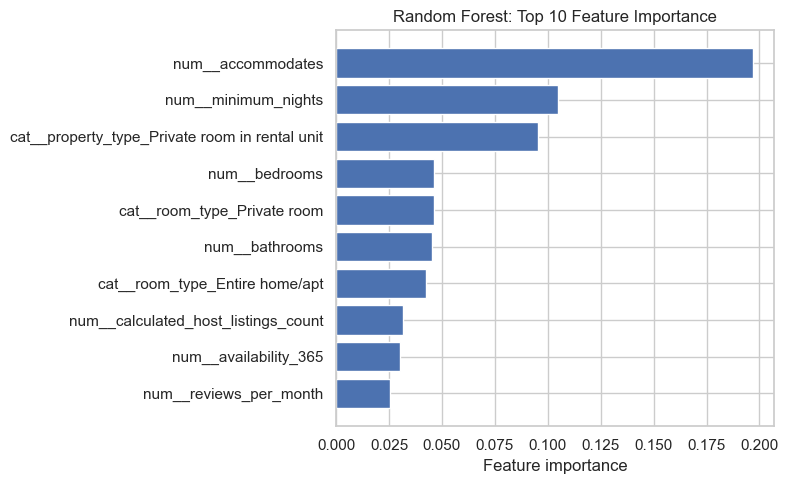

In [45]:
# Random Forest feature importance 
rf_model = best_rf.named_steps["model"]
rf_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False).reset_index(drop=True)

rf_top10 = rf_imp.head(10)

print("Random Forest - Top 10 features")

plt.figure(figsize=(8, 5))

# reverse order so the most important feature is on top
plt.barh(
    rf_top10["feature"][::-1],
    rf_top10["importance"][::-1]
)

plt.title("Random Forest: Top 10 Feature Importance")
plt.xlabel("Feature importance")
plt.tight_layout()

plt.savefig(FIGURES_DIR / "rf_top10_feature_importance.png", dpi=150)
plt.show()

XGBoost - Top 10 features


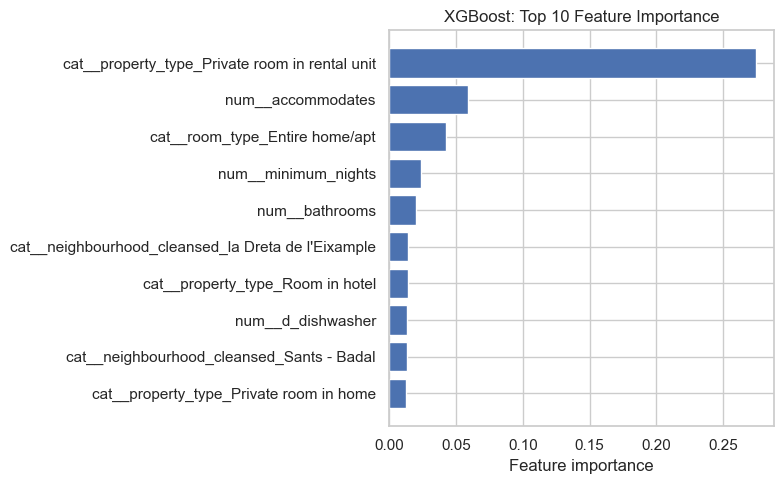

In [46]:
# XGBoost feature importance

xgb_model = best_xgb.named_steps["model"]

xgb_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": xgb_model.feature_importances_
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)
)

xgb_top10 = xgb_imp.head(10)

print("XGBoost - Top 10 features")

plt.figure(figsize=(8, 5))

plt.barh(
    xgb_top10["feature"][::-1],
    xgb_top10["importance"][::-1]
)

plt.title("XGBoost: Top 10 Feature Importance")
plt.xlabel("Feature importance")
plt.tight_layout()

plt.savefig(FIGURES_DIR / "xgb_top10_feature_importance.png", dpi=150)
plt.show()



Both models identify listing capacity and accommodation type as the primary drivers of Airbnb prices.  
For Random Forest, the most important predictor is the number of accommodates, followed by minimum nights, bedrooms, bathrooms, and room/property type indicators. Importance is relatively spread across several size and availability variables.

XGBoost places even stronger emphasis on categorical accommodation type, particularly private rooms in rental units and entire homes/apartments. Capacity (accommodates) remains highly important, but XGBoost concentrates importance on fewer features and assigns more weight to specific neighbourhood and amenity indicators.

Both models agree that size, room type, and property type dominate price formation, while XGBoost relies more heavily on a smaller set of highly informative predictors, consistent with its boosting-based learning strategy.


### Part 2. Validity

In [47]:
# Download data

URL_BARCELONA_Q3_2025 = "https://data.insideairbnb.com/spain/catalonia/barcelona/2025-09-14/data/listings.csv.gz"
URL_SEVILLA_Q3_2025   = "https://data.insideairbnb.com/spain/andaluc%C3%ADa/sevilla/2025-09-29/data/listings.csv.gz"

In [ ]:
# Repeatable wrangling function (same logic as Part I)

def load_and_prepare(url, top_amenities, predictors):
    """
    Load listings data from a URL and apply the SAME wrangling as in Part I:
    - Clean price to numeric
    - Drop missing/non-positive price
    - Create log_price
    - Create amenity dummies for the same top_amenities used in training
    - Ensure predictor columns exist
    Returns: df_prepared, X, y
    """
    df_raw_new = pd.read_csv(url)
    df_new = df_raw_new.copy()

    # Clean price 
    df_new["price"] = (
        df_new["price"]
        .astype(str)
        .str.replace(r"[\$,]", "", regex=True)
    )
    df_new["price"] = pd.to_numeric(df_new["price"], errors="coerce")

    # Drop missing / invalid target
    df_new = df_new.dropna(subset=["price"])
    df_new = df_new.loc[df_new["price"] > 0].copy()

    # Log transform target
    df_new["log_price"] = np.log(df_new["price"])

    # Amenities: create the same d_ variables as in training 
    amenities_series = (
        df_new["amenities"]
        .astype(str)
        .str.replace(r"[{}\"]", "", regex=True)
        .str.split(",")
    )
    amenities_series = amenities_series.apply(lambda x: [a.strip() for a in x if isinstance(a, str)])

    for amenity in top_amenities:
        col_name = "d_" + amenity.lower().replace(" ", "_").replace("/", "_")
        df_new[col_name] = amenities_series.apply(lambda x: int(amenity in x))

    # Ensure all predictors exist (important for other city)
    for col in predictors:
        if col not in df_new.columns:
            df_new[col] = np.nan

    X = df_new[predictors].copy()
    y = df_new["log_price"].copy()

    return df_new, X, y

In [49]:
# Prepare A and B datasets

df_A, X_A, y_A = load_and_prepare(URL_BARCELONA_Q3_2025, top_amenities, PREDICTORS)
df_B, X_B, y_B = load_and_prepare(URL_SEVILLA_Q3_2025, top_amenities, PREDICTORS)

print("A (Barcelona Q3 2025) rows:", df_A.shape[0])
print("B (Sevilla Q3 2025) rows:", df_B.shape[0])


A (Barcelona Q3 2025) rows: 15276
B (Sevilla Q3 2025) rows: 7581


In [50]:
# Evaluate the 5 core models on A and B

def evaluate(model, X, y):
    pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    return rmse, r2

models = {
    "OLS": ols_model,
    "LASSO": lasso_model,
    "Random Forest": best_rf,
    "XGBoost": best_xgb,
    "CART": best_cart
}

rows = []
for name, model in models.items():
    rmse_A, r2_A = evaluate(model, X_A, y_A)
    rmse_B, r2_B = evaluate(model, X_B, y_B)

    rows.append({
        "Model": name,
        "RMSE A (BCN Q3)": rmse_A,
        "R² A (BCN Q3)": r2_A,
        "RMSE B (Sevilla)": rmse_B,
        "R² B (Sevilla)": r2_B
    })

validity_results = pd.DataFrame(rows)
validity_results

,Model,RMSE A (BCN Q3),R² A (BCN Q3),RMSE B (Sevilla),R² B (Sevilla)
0,OLS,0.505499,0.620842,0.581001,0.307667
1,LASSO,0.504902,0.621736,0.579980,0.310097
2,Random Forest,0.394364,0.769233,0.583183,0.302457
3,XGBoost,0.409118,0.751643,0.573101,0.326368
4,CART,0.493400,0.638775,0.671821,0.074303


In [51]:
validity_results.to_csv(TABLES_DIR / "validity_results.csv", index=False)

In [52]:
# Compare performance vs Part I holdout

base = results.rename(columns={"RMSE (log)": "RMSE Base", "R²": "R² Base"})[["Model", "RMSE Base", "R² Base"]]
validity_compare = base.merge(validity_results, on="Model", how="left")

validity_compare["ΔRMSE A"] = validity_compare["RMSE A (BCN Q3)"] - validity_compare["RMSE Base"]
validity_compare["ΔRMSE B"] = validity_compare["RMSE B (Sevilla)"] - validity_compare["RMSE Base"]

validity_compare


,Model,RMSE Base,R² Base,RMSE A (BCN Q3),R² A (BCN Q3),RMSE B (Sevilla),R² B (Sevilla),ΔRMSE A,ΔRMSE B
0,XGBoost,0.371287,0.760472,0.409118,0.751643,0.573101,0.326368,0.037831,0.201813
1,Random Forest,0.372910,0.758374,0.394364,0.769233,0.583183,0.302457,0.021454,0.210273
2,LASSO,0.445202,0.655610,0.504902,0.621736,0.579980,0.310097,0.059700,0.134778
3,OLS,0.447101,0.652666,0.505499,0.620842,0.581001,0.307667,0.058398,0.133900
4,CART,0.489461,0.583732,0.493400,0.638775,0.671821,0.074303,0.003938,0.182360


In [53]:
validity_compare.to_csv(TABLES_DIR / "validity_compare_vs_base.csv", index=False)

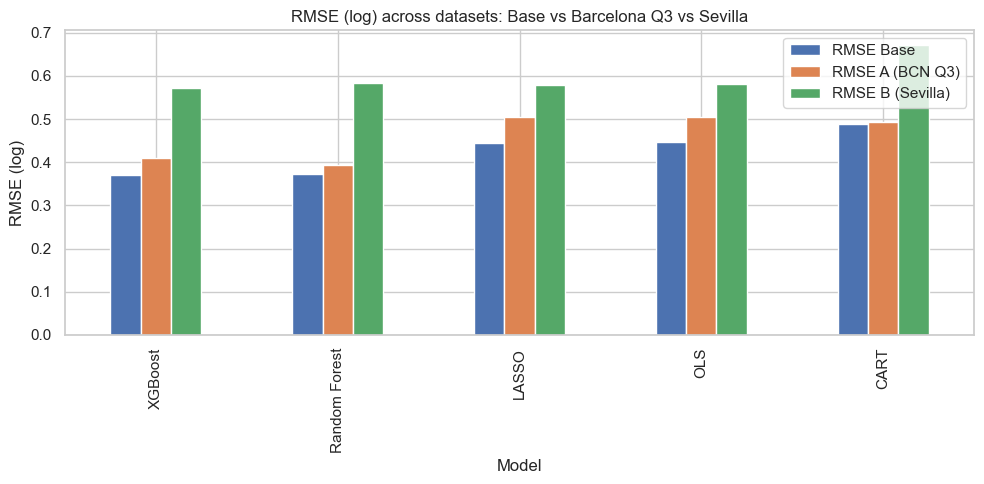

In [54]:
# Simple RMSE comparison plot (Base vs A vs B)

plot_df = validity_compare[["Model", "RMSE Base", "RMSE A (BCN Q3)", "RMSE B (Sevilla)"]].set_index("Model")
plot_df.plot(kind="bar", figsize=(10, 5))

plt.title("RMSE (log) across datasets: Base vs Barcelona Q3 vs Sevilla")
plt.ylabel("RMSE (log)")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "rmse_validity_comparison.png", dpi=150)
plt.show()

#### Validity across time and location

Model performance declines when evaluated on new datasets, as expected.  
On the later Barcelona snapshot (Q3 2025), all models exhibit moderate increases in RMSE and slight reductions in R². Tree-based models (Random Forest and XGBoost) show the smallest performance degradation, indicating better robustness over time compared to linear models.

When applied to Sevilla, performance drops substantially for all models, with large reductions in R². This highlights limited geographic transferability when models are trained on a single city, as pricing structures and neighborhood effects differ across locations. Despite this, Random Forest and XGBoost remain the best-performing models, while CART performs poorly, suggesting underfitting and weak generalization.

Overall, the results confirm that flexible, non-linear models generalize better across time and space, but cross-city prediction remains challenging without city-specific training data.
